# Football transfer fee predictor

#### Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

### Data Acquisition

#### Importing the data from csv file into a Dataframe.

In [2]:
football_transfers_data = pd.read_csv('./football_data/transfers.csv', sep = ',')

In [3]:
football_transfers_data.head(10)

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Season,Market_value,Transfer_fee
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,NaN,60000000
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,NaN,56810000
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,NaN,40000000
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,NaN,36150000
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,NaN,34500000
5,Rio Ferdinand,Centre-Back,22,West Ham,Premier League,Leeds,Premier League,2000-2001,NaN,26000000
6,Flávio Conceicao,Central Midfield,26,Dep. La Coruña,LaLiga,Real Madrid,LaLiga,2000-2001,NaN,25000000
7,Savo Milosevic,Centre-Forward,26,Real Zaragoza,LaLiga,Parma,Serie A,2000-2001,NaN,25000000
8,David Trézéguet,Centre-Forward,22,Monaco,Ligue 1,Juventus,Serie A,2000-2001,NaN,23240000
9,Claudio López,Centre-Forward,25,Valencia CF,LaLiga,Lazio,Serie A,2000-2001,NaN,23000000


### Data Cleaning

#### Dropping the columns containing no values.

In [4]:
football_transfers_data=football_transfers_data.dropna(axis=1, how='any')

In [5]:
positions = football_transfers_data['Position'].unique().tolist()
print(positions)
age = football_transfers_data['Age'].unique().tolist()
print(age)

['Right Winger', 'Centre-Forward', 'Left Winger', 'Centre-Back', 'Central Midfield', 'Attacking Midfield', 'Defensive Midfield', 'Second Striker', 'Goalkeeper', 'Right-Back', 'Left Midfield', 'Left-Back', 'Right Midfield', 'Forward', 'Sweeper', 'Defender', 'Midfielder']
[27, 25, 31, 21, 22, 26, 28, 23, 19, 24, 30, 20, 29, 35, 18, 32, 0, 33, 34, 17, 16, 15]


#### Dropping irrelevant data (positions that are too generic)

In [6]:
drop_positions = ['Forward','Sweeper','Defender','Midfielder']
drop_age = [0]
football_transfers_data['Position'] = football_transfers_data['Position'].replace(drop_positions,np.nan)
football_transfers_data['Age'] = football_transfers_data['Age'].replace(drop_age,np.nan)

In [7]:
football_transfers_data=football_transfers_data.dropna()
positions = football_transfers_data['Position'].unique().tolist()
print(positions)
age = football_transfers_data['Age'].unique().tolist()
print(age)

['Right Winger', 'Centre-Forward', 'Left Winger', 'Centre-Back', 'Central Midfield', 'Attacking Midfield', 'Defensive Midfield', 'Second Striker', 'Goalkeeper', 'Right-Back', 'Left Midfield', 'Left-Back', 'Right Midfield']
[27.0, 25.0, 31.0, 21.0, 22.0, 26.0, 28.0, 23.0, 19.0, 24.0, 30.0, 20.0, 29.0, 35.0, 18.0, 32.0, 33.0, 34.0, 17.0, 16.0, 15.0]


In [8]:
football_transfers_data.Age = football_transfers_data.Age.astype(int)
age = football_transfers_data['Age'].unique().tolist()
print(age)

[27, 25, 31, 21, 22, 26, 28, 23, 19, 24, 30, 20, 29, 35, 18, 32, 33, 34, 17, 16, 15]


In [9]:
football_transfers_data['Transfer_fee'] = football_transfers_data['Transfer_fee']/1e6
cols = {'Name':'Name', 'Age':'Age', 'Team_from':'Team_from', 'League_from':'League_from','Team_to':'Team_to', 'League_to':'League_to', 'Season':'Season', 'Transfer_fee':'Transfer_fee in millions'}
football_transfers_data=football_transfers_data.rename(columns = cols)
football_transfers_data.head(10)

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Season,Transfer_fee in millions
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,60.00
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,56.81
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,40.00
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,36.15
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,34.50
5,Rio Ferdinand,Centre-Back,22,West Ham,Premier League,Leeds,Premier League,2000-2001,26.00
6,Flávio Conceicao,Central Midfield,26,Dep. La Coruña,LaLiga,Real Madrid,LaLiga,2000-2001,25.00
7,Savo Milosevic,Centre-Forward,26,Real Zaragoza,LaLiga,Parma,Serie A,2000-2001,25.00
8,David Trézéguet,Centre-Forward,22,Monaco,Ligue 1,Juventus,Serie A,2000-2001,23.24
9,Claudio López,Centre-Forward,25,Valencia CF,LaLiga,Lazio,Serie A,2000-2001,23.00


### Data preparation

In [10]:
position_data = football_transfers_data.groupby(football_transfers_data['Position'])
# (position_data.get_group('Goalkeeper')['Transfer_fee in millions']).sum()

In [11]:
total_transfer_cost_by_position = [{position : (position_data.get_group(position)['Transfer_fee in millions']).sum()} for position in positions]
total_transfer_cost_by_position

[{'Right Winger': 3638.7599999999998},
 {'Centre-Forward': 11678.95},
 {'Left Winger': 3445.54},
 {'Centre-Back': 6032.295},
 {'Central Midfield': 4916.870000000001},
 {'Attacking Midfield': 4185.1},
 {'Defensive Midfield': 3695.72},
 {'Second Striker': 1142.72},
 {'Goalkeeper': 1372.08},
 {'Right-Back': 1494.0299999999997},
 {'Left Midfield': 584.39},
 {'Left-Back': 1736.7599999999998},
 {'Right Midfield': 466.46}]

### Data visualization

#### Plotting the transfer fee (in millions) based on each position.

<BarContainer object of 13 artists>

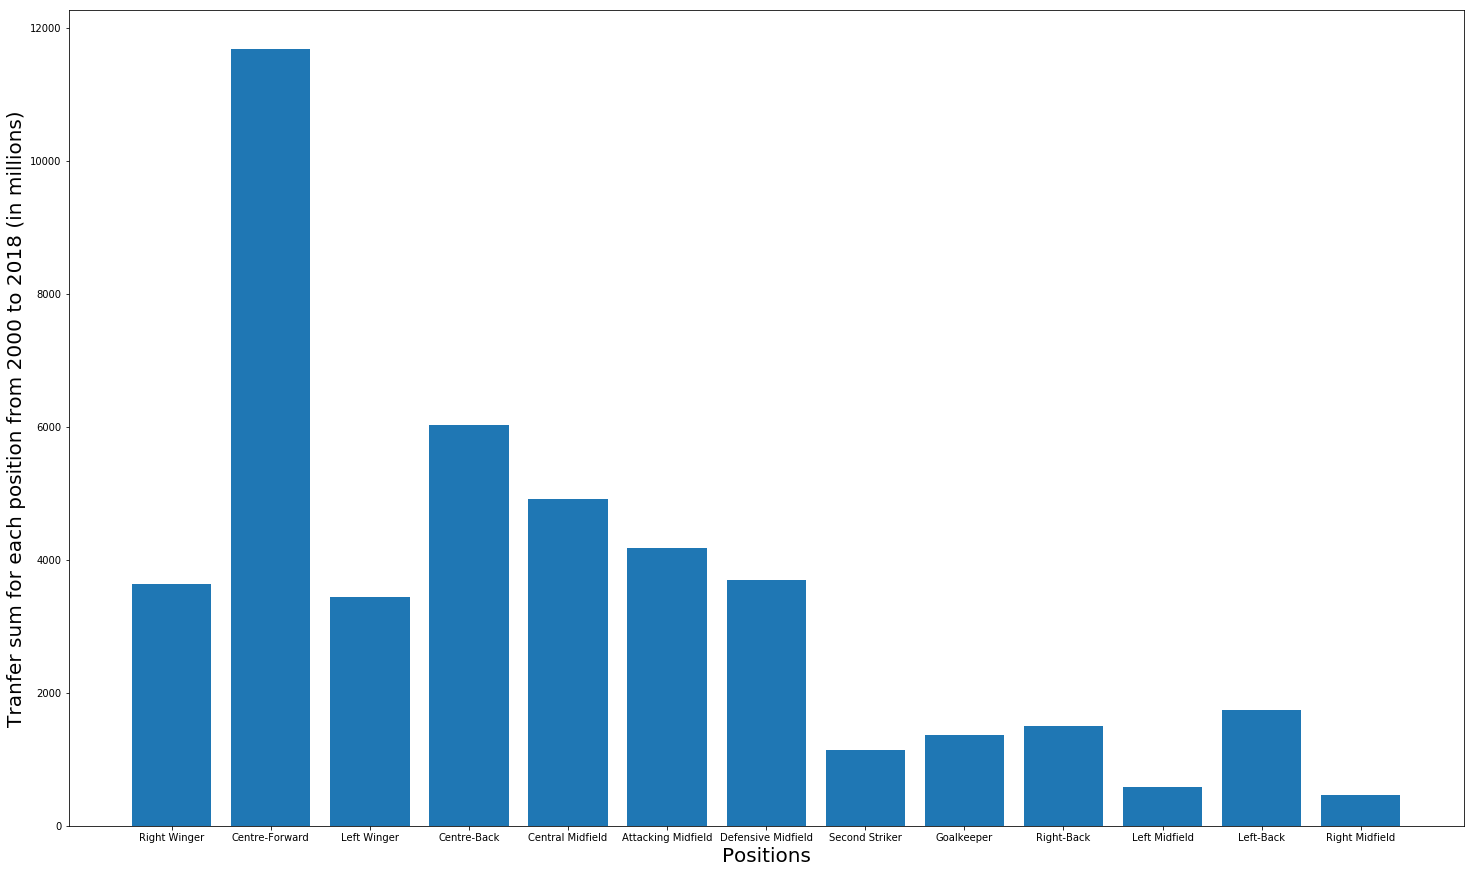

In [12]:
pos = []
transfer_sum = []
for tc in total_transfer_cost_by_position:
    for position, transfer_cost in tc.items():
        pos.append(position)
        transfer_sum.append(transfer_cost)
# print(pos)
# print(transfer_sum)
plt.figure(figsize=(25,15))
plt.xlabel("Positions", fontsize=20)
plt.ylabel("Tranfer sum for each position from 2000 to 2018 (in millions)", fontsize=20)
plt.bar(pos,transfer_sum)

#### Plotting the trend over the years of transfer fee for each position.

Text(0,0.5,'Transfer fee in millions')

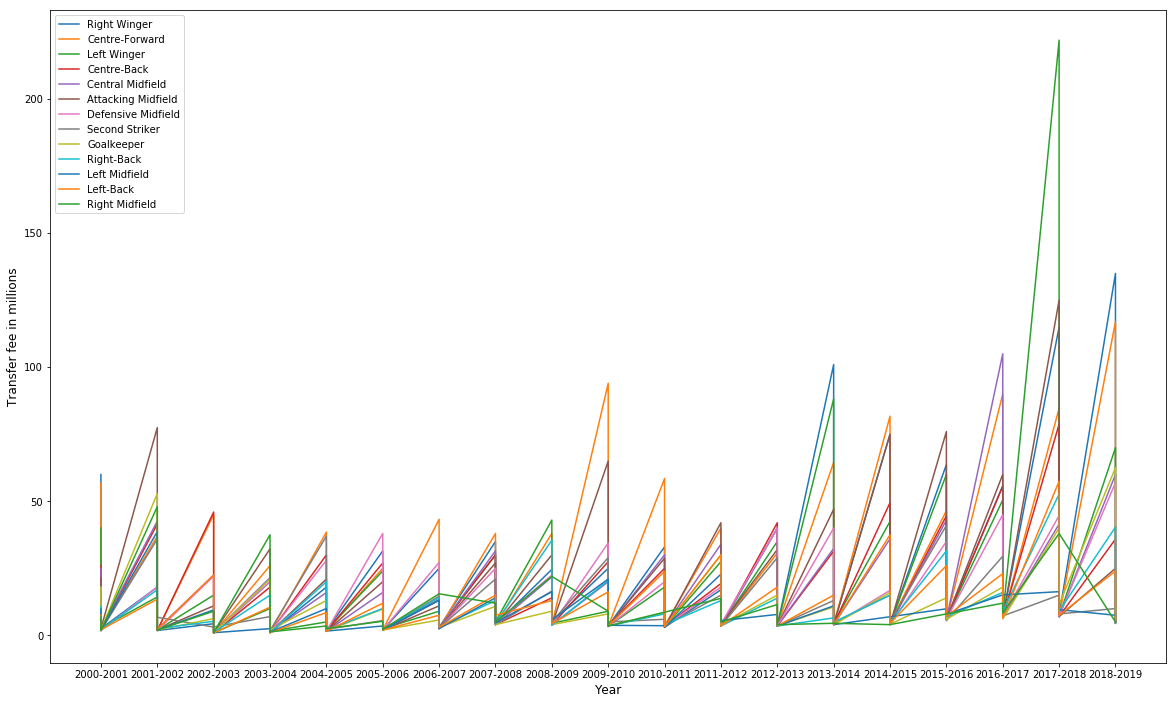

In [13]:
plt.figure(figsize=(20,12))
for p in pos:
    plt.plot(position_data.get_group(p)['Season'], position_data.get_group(p)['Transfer_fee in millions'], label=p)
plt.legend()
plt.xlabel('Year',fontsize=12)
plt.ylabel('Transfer fee in millions',fontsize=12)

In [14]:
seasons = football_transfers_data['Season'].tolist()
for s in range(len(seasons)):
    seasons[s] = seasons[s][:4]
# print(seasons)
football_transfers_data['Season'] = seasons
football_transfers_data.head(10)

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Season,Transfer_fee in millions
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000,60.00
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000,56.81
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000,40.00
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000,36.15
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000,34.50
5,Rio Ferdinand,Centre-Back,22,West Ham,Premier League,Leeds,Premier League,2000,26.00
6,Flávio Conceicao,Central Midfield,26,Dep. La Coruña,LaLiga,Real Madrid,LaLiga,2000,25.00
7,Savo Milosevic,Centre-Forward,26,Real Zaragoza,LaLiga,Parma,Serie A,2000,25.00
8,David Trézéguet,Centre-Forward,22,Monaco,Ligue 1,Juventus,Serie A,2000,23.24
9,Claudio López,Centre-Forward,25,Valencia CF,LaLiga,Lazio,Serie A,2000,23.00


In [15]:
leagues_to_list = football_transfers_data['League_to'].unique().tolist()
print(len(leagues_to_list))
print(leagues_to_list)

64
['LaLiga', 'Serie A', 'Ligue 1', 'Premier League', ' Scotland', 'Süper Lig', '1.Bundesliga', 'Eredivisie', 'Liga NOS', ' Brazil', ' England', 'Super League', 'Bundesliga', 'First Division', 'Jupiler Pro League', 'Serie B', 'Premier Liga', ' Portugal', ' United Arab Emirates', ' Wales', 'J2 League', ' Venezuela', ' Argentina', ' China', ' Mexico', ' Czech Republic', ' Saudi Arabia', ' Croatia', ' Libya', ' Israel', 'Second Division (bis 03/04)', 'J1 - 2nd Stage', ' Bulgaria', ' Denmark', ' Sweden', ' Romania', ' Korea, South', 'Série A', 'Premiership', 'Serie C - B', 'Championship', ' Qatar', 'Superligaen', 'Allsvenskan', 'J1 League', 'SuperLiga', 'Torneo Final', 'Eliteserien', 'Liga MX Clausura', '2.Bundesliga', 'LaLiga2', 'Professional League', 'Primavera B', ' Russia', 'Stars League', 'Ligue 2', 'MLS', 'UAE Gulf League', 'Primera División', 'Segunda División - Segunda Fase', 'League One', 'Ledman Liga Pro', ' Uruguay', 'Liga MX Apertura']


### Model Generation

In [16]:
encoder = LabelEncoder()
football_transfers_data['Position_code'] = encoder.fit_transform(football_transfers_data['Position'])
football_transfers_data['Age_code'] = encoder.fit_transform(football_transfers_data['Age'])
football_transfers_data['Team_from_code'] = encoder.fit_transform(football_transfers_data['Team_from'])
football_transfers_data['League_from_code'] = encoder.fit_transform(football_transfers_data['League_from'])
football_transfers_data['Team_to_code'] = encoder.fit_transform(football_transfers_data['Team_to'])
football_transfers_data['League_to_code'] = encoder.fit_transform(football_transfers_data['League_to'])
football_transfers_data.head()

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Season,Transfer_fee in millions,Position_code,Age_code,Team_from_code,League_from_code,Team_to_code,League_to_code
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000,60.00,10,12,182,68,241,35
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000,56.81,3,10,385,97,175,53
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000,40.00,7,12,43,84,109,35
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000,36.15,3,16,216,97,9,53
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000,34.50,3,6,425,68,219,42


In [17]:
features = ['Position_code', 'Age_code', 'Team_from_code', 'League_from_code', 'Team_to_code', 'League_to_code', 'Season']
X_train, X_test, Transfer_fee_train, Transfer_fee_test = train_test_split(football_transfers_data[features], football_transfers_data['Transfer_fee in millions'], test_size=0.33, random_state=324)
data_model = DecisionTreeRegressor(random_state=1)
data_model.fit(football_transfers_data[features], football_transfers_data['Transfer_fee in millions'])


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [18]:
Predicted_Transfer_fee = data_model.predict(X_test)
print(mean_absolute_error(Transfer_fee_test, Predicted_Transfer_fee))

0.00029051000645577787
